# Sysgro ROI Length

This notebook loads the polygons which are linked to the images of idr0001-graml-sysgro and compares the length of cells labelled with a particular gene e.g. ASH2 versus the wild type.

### Dependencies

 * [Matplotlib](https://matplotlib.org/)
 * [NumPy](https://www.numpy.org/)
 * [Pandas](https://pandas.pydata.org/)
 * [Scikit-image](https://scikit-image.org/)

In [1]:
from idr import connection
from pandas import Series
from pandas import DataFrame
from pandas import read_csv
from pandas import merge,concat
from pandas import read_hdf

import os
import omero

import numpy as np
import matplotlib.pyplot as plt
import skimage.measure as skmes
import skimage.transform as sktrans

### Common variables

In [2]:
screenId = 3  # sysgro

### Method definitions

In [3]:
def getBulkAnnotationAsDf(screenID, conn):
    """
    Download the annotation file from a screen as a Pandas DataFrame
    """
    screen = conn.getObject('Screen', screenID)
    for ann in screen.listAnnotations():
        if isinstance(ann, omero.gateway.FileAnnotationWrapper):
            if (ann.getFile().getName() == 'bulk_annotations'):
                if (ann.getFile().getSize() > 147625090):
                    print "that's a big file..."
                    return None
                ofId = ann.getFile().getId()
                break


    original_file = omero.model.OriginalFileI(ofId, False)
    table = conn.c.sf.sharedResources().openTable(original_file)
    try:
        rowCount = table.getNumberOfRows()
        column_names = [col.name for col in table.getHeaders()]

        black_list = []
        column_indices = []
        for column_name in column_names:
            if column_name in black_list:
                continue
            column_indices.append(column_names.index(column_name))

        table_data = table.slice(column_indices, None)
    finally:
        table.close()

    data = []
    for index in range(rowCount):
        row_values = [column.values[index] for column in table_data.columns]
        data.append(row_values)

    dfAnn = DataFrame(data)
    dfAnn.columns = column_names
    return dfAnn

In [4]:
def getLengthsFromStrain(astrain, lenlen=100, verbose=False):
    lengths = []
    params = omero.sys.ParametersI()
    wellids = sysgroba[sysgroba["Characteristics [Strain]"] == astrain].Well.values
    params.addIds(wellids)
    # Wells and images that contain a ROI
    imageswithrois = queryService.projection(
        'SELECT w.id, i.id FROM Image i JOIN i.wellSamples s JOIN s.well w '
        'WHERE w.id in (:ids) AND EXISTS '
        '(SELECT 1 FROM Roi AS r WHERE r.image = i) ORDER BY i.id', params)
    wellswithrois = {}
    for wid, iid in omero.rtypes.unwrap(imageswithrois):
        try:
            wellswithrois[wid].append(iid)
        except KeyError:
            wellswithrois[wid] = [iid]

    for wid in sorted(wellswithrois.keys()):
        for imId in wellswithrois[wid]:
            result = roiService.findByImage(imId, None)
            if verbose:
                print('Well-id:%d Image-id:%d rois:[%d]' % (wid, imId, len(result.rois)))
            for ii in range(len(result.rois)):

                # get the coordinates of the outline of the ROI
                s = result.rois[ii].copyShapes()[0]
                pts = s.getPoints().getValue()
                pts = [int(xx) for x in pts.split(' ') for xx in x.split(',') ]
                pts = np.reshape(pts, (len(pts)/2, 2))

                # from coordinates to mask image
                M0, m0, M1, m1 = pts[:,0].max(), pts[:,0].min(), pts[:,1].max(), pts[:,1].min()
                imroi = np.zeros((M0-m0+1, M1-m1+1))
                for i in range(pts.shape[0]):
                    imroi[pts[i, 0]-m0, pts[i, 1]-m1] = 1    

                iml = skmes.label(1-imroi, connectivity=1)
                imroi = 1*(iml==iml[iml.shape[0]/2, iml.shape[1]/2])

                # length of cell as length of bounding box of rotated image
                # (thanks to the particular shape of yeast cells)
                # default orientation is changing in 0.16 so -pi/2 to make relative to x-axis
                # http://scikit-image.org/docs/0.14.x/release_notes_and_installation.html#deprecations
                ori = skmes.regionprops(1 * imroi, coordinates='rc')[0].orientation - (np.pi / 2)
                imroi = sktrans.rotate(1. * imroi, -ori/(np.pi)*180, resize=True, order=0)
                bbox = skmes.regionprops(skmes.label(imroi), coordinates='rc')[0].bbox
                lengths.append(bbox[3] - bbox[1])
        if len(lengths) > lenlen: # to speed things up when there are a lot of images...
            break
    return lengths

### Connect

In [5]:
conn = connection()


Connected to IDR ...


### Load data

In [6]:
roiService = conn.getRoiService()
queryService = conn.getQueryService()
sysgroba = getBulkAnnotationAsDf(screenId, conn)

### Extract length of cells as stored in ROIs in the IDR

In [7]:
WTls = getLengthsFromStrain('MS1404', lenlen=1000)
ash2ls = getLengthsFromStrain('ash2', lenlen=1000)

pixsize = .11  # could be taken from IDR metadata
ash2ls = [x * pixsize for x in ash2ls]
WTls = [x * pixsize for x in WTls]

### Disconnect when done loading data

In [8]:
conn.close()

### Display comparison of wild type to perturbed cells

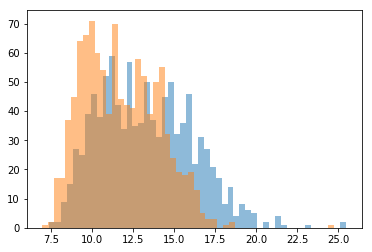

In [9]:
plt.figure()
h1 = plt.hist(ash2ls, bins=50, alpha=.5)
h2 = plt.hist(WTls, bins=50, alpha=.5) 

In [10]:
from scipy.stats import ttest_ind
ttest_ind(WTls, ash2ls)

Ttest_indResult(statistic=-13.398273380158818, pvalue=2.5160251562338347e-39)

### License

Copyright (C) 2017 University of Dundee. All Rights Reserved.

This program is free software; you can redistribute it and/or modify it under the terms of the GNU General Public License as published by the Free Software Foundation; either version 2 of the License, or (at your option) any later version.

This program is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the GNU General Public License for more details.
You should have received a copy of the GNU General Public License along with this program; if not, write to the Free Software Foundation, Inc., 51 Franklin Street, Fifth Floor, Boston, MA 02110-1301 USA.